**AI & Machine Learning (KAN-CINTO4003U) - Copenhagen Business School | Spring 2025**

***


# Part I: RAG

Please see the description of the assignment in the README file (section 1) <br>
**Guide notebook**: [guides/rag_guide.ipynb](guides/rag_guide.ipynb)


***
<br>

* Remember to include some reflections on your results. Are there, for example, any hyperparameters that are particularly important?

* You should follow the steps given in the `rag_guide` notebook to create your own RAG system.

<br>

***

#### Imports

In [11]:
# Install the required package
%pip install langchain-ibm

from decouple import config
import os
from dotenv import load_dotenv

from langchain_ibm import WatsonxLLM
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams

Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 26.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 42.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install chroma


  Preparing metadata (setup.py) ...   Downloading Chroma-0.2.0.tar.gz (5.8 kB)
  Preparing metadata (setup.py) ... done
done
  Created wheel for chroma: filename=Chroma-0.2.0-py3-none-any.whl size=7138 sha256=a69c249e2f73f34a2d01b66193620b15a9be43de01ed90a23ca36ad0e856399b
  Stored in directory: /Users/wenlong/Library/Caches/pip/wheels/58/74/75/a6ab7999ae473ecbe819bc5cae9ccb902429dd6c60795f5112
Successfully built chroma
done
  Created wheel for chroma: filename=Chroma-0.2.0-py3-none-any.whl size=7138 sha256=a69c249e2f73f34a2d01b66193620b15a9be43de01ed90a23ca36ad0e856399b
  Stored in directory: /Users/wenlong/Library/Caches/pip/wheels/58/74/75/a6ab7999ae473ecbe819bc5cae9ccb902429dd6c60795f5112
Successfully built chroma
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [23]:
from typing import Literal, Any
from copy import deepcopy
import langchain_chroma

from typing_extensions import TypedDict
import matplotlib.pyplot as plt
import numpy as np
from decouple import config
from pydantic import BaseModel, Field
from IPython.display import Image, display
from tqdm import tqdm

from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters.markdown import MarkdownHeaderTextSplitter
from langchain.prompts import PromptTemplate
from langchain_ibm import WatsonxEmbeddings
from langchain_ibm import WatsonxLLM
from langgraph.graph import START, StateGraph
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams

import litellm
from litellm import completion
import instructor
from instructor import Mode

#### Retrieve secrets

In [24]:
import os
from dotenv import load_dotenv
from decouple import config


env_path = "/Users/wenlong/Documents/GitHub/ma3/assignments/.env"
load_dotenv(dotenv_path=env_path)

WX_API_KEY = config("WX_API_KEY")
WX_PROJECT_ID = config("WX_PROJECT_ID")
WX_API_URL = "https://us-south.ml.cloud.ibm.com"




In [29]:
import re
import unicodedata

def preprocess_text(text: str) -> str:
    """
    Basic document preprocessing:
    - Normalize Unicode characters
    - Remove HTML tags
    - Remove unwanted special characters
    - Normalize whitespace
    - Convert to lowercase
    """
    text = unicodedata.normalize("NFKC", text)
    text = re.sub(r"<[^>]+>", " ", text)  # Remove HTML
    text = re.sub(r"[^a-zA-Z0-9.,;:!?()\-\'\"\n ]+", " ", text)  # Clean special chars
    text = re.sub(r"\s+", " ", text)  # Normalize whitespace
    return text.strip().lower()


#### Authenticate and initialize LLM

In [60]:
llm = WatsonxLLM(

        model_id= "mistralai/mistral-large",
        url=WX_API_URL,
        apikey=WX_API_KEY,
        project_id=WX_PROJECT_ID,

        params={
            GenParams.DECODING_METHOD: "greedy",
            GenParams.TEMPERATURE: 0,
            GenParams.MIN_NEW_TOKENS: 5,
            GenParams.MAX_NEW_TOKENS: 1_000,
            GenParams.REPETITION_PENALTY:1.2
        }

)

#### Use LLM

In [61]:
llm_result = llm.generate(["Hi how are you?"])

print(type(llm_result))
print(llm_result)

for chunk in llm.stream(
    "Describe your favorite breed of dog and why it is your favorite."
):
    print(chunk, end="")

<class 'langchain_core.outputs.llm_result.LLMResult'>
generations=[[Generation(text='\nI have a question about the use of "the" in this sentence:\n\nThe first thing I do when I get home is to take off my shoes. The second thing I do is (to) wash my hands and face with soap and water, then dry them on a clean towel. After that, I change into comfortable clothes before starting any other activity at home like cooking dinner or watching TV shows online from Netflix streaming service which has become very popular lately because it offers unlimited access for only $8 per month! It\'s really convenient since there are no commercials interrupting your favorite show every few minutes as they used to be back in the days when we had cable television services instead of internet-based ones such as Hulu Plus ($7/month), Amazon Prime Video($99 annually but includes free shipping benefits too!) etcetera... What should come after “is” ? To or nothing??', generation_info={'finish_reason': 'eos_token'}

In [62]:
document = TextLoader("data/madeup_company.md").load()[0]

# Preprocess content
raw_text = document.page_content
cleaned_text = preprocess_text(raw_text)
document.page_content = cleaned_text

print("Before:\n", raw_text[:500])
print("\nAfter:\n", cleaned_text[:500])


Before:
 # About MadeUpCompany
MadeUpCompany is a pioneering technology firm founded in 2010, specializing in cloud computing, data analytics, and machine learning. Headquartered in San Francisco, California, we have a global presence with satellite offices in New York, London, and Tokyo. Our mission is to empower businesses and individuals with cutting-edge technology that enhances efficiency, scalability, and innovation.

With a diverse team of experts from various industries—including AI research, cyb

After:
 about madeupcompany madeupcompany is a pioneering technology firm founded in 2010, specializing in cloud computing, data analytics, and machine learning. headquartered in san francisco, california, we have a global presence with satellite offices in new york, london, and tokyo. our mission is to empower businesses and individuals with cutting-edge technology that enhances efficiency, scalability, and innovation. with a diverse team of experts from various industries including 

In [63]:
embed_params = {}

watsonx_embedding = WatsonxEmbeddings(
    model_id="ibm/granite-embedding-278m-multilingual",
    url=WX_API_URL,
    project_id=WX_PROJECT_ID,
    apikey=WX_API_KEY,
    params=embed_params,
)

In [85]:
from langchain_community.document_loaders import TextLoader

# Load raw document
document = TextLoader("data/madeup_company.md").load()[0]

# Preprocess the content
raw_text = document.page_content
cleaned_text = preprocess_text(raw_text)
document.page_content = cleaned_text

# Chunk the preprocessed document
headers_to_split_on = [("#", "Header 1"), ("##", "Header 2"), ("###", "Header 3"), ("####", "Header 4")]

from langchain_text_splitters import RecursiveCharacterTextSplitter, MarkdownHeaderTextSplitter

# First, split based on Markdown headers
markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
header_chunks = markdown_splitter.split_text(document.page_content)

# # Then, apply a secondary splitter that limits chunk size
# token_safe_splitter = RecursiveCharacterTextSplitter(
#     chunk_size=450,       # below 512-token limit
#     chunk_overlap=50,     # some overlap to preserve context
# )

# # Flatten out any large chunks further
# safe_chunks = token_safe_splitter.split_documents(header_chunks)



# Improved chunking using hierarchical separators
token_safe_splitter = RecursiveCharacterTextSplitter(
    chunk_size=300,
    chunk_overlap=60,
    separators=["\n\n", "\n", ".", " ", ""],  # Try larger chunks first, then break smaller
)

safe_chunks = token_safe_splitter.split_documents(header_chunks)



docs = update_documents_with_headers(safe_chunks)

local_vector_db = Chroma.from_documents(
    collection_name="my_collection",
    embedding=watsonx_embedding,
    persist_directory="my_vector_db",
    documents=docs,
)

In [86]:
safe_chunks

[Document(metadata={}, page_content='about madeupcompany madeupcompany is a pioneering technology firm founded in 2010, specializing in cloud computing, data analytics, and machine learning. headquartered in san francisco, california, we have a global presence with satellite offices in new york, london, and tokyo'),
 Document(metadata={}, page_content='. our mission is to empower businesses and individuals with cutting-edge technology that enhances efficiency, scalability, and innovation'),
 Document(metadata={}, page_content='. with a diverse team of experts from various industries including ai research, cybersecurity, and enterprise software development we push the boundaries of what s possible'),
 Document(metadata={}, page_content='. our commitment to continuous improvement, security, and customer success has earned us recognition as a leader in the tech space. our values at madeupcompany, we believe in: - innovation continuously developing and refining solutions that meet the evol

In [87]:
from copy import deepcopy

def update_documents_with_headers(chunks):
    """
    Creates a new list of Document objects with page_content prepended with headers
    in [Header1/Header2/Header3]: format
    
    Returns new objects rather than modifying the original chunks
    """
    updated_chunks = []
    
    for doc in chunks:
        # Create a deep copy of the document to avoid modifying the original
        new_doc = deepcopy(doc)
        
        # Get all headers that exist in metadata
        headers = []
        for i in range(1, 4):
            key = f'Header {i}'
            if key in new_doc.metadata:
                headers.append(new_doc.metadata[key])
        
        # Create the header prefix and update page_content
        if headers:
            prefix = f"[{'/'.join(headers)}]: "
            new_doc.page_content = prefix + "\n" + new_doc.page_content
        
        updated_chunks.append(new_doc)
    
    return updated_chunks


docs = update_documents_with_headers(safe_chunks)

In [88]:
for doc in docs:
    print(doc.page_content, end="\n\n")

about madeupcompany madeupcompany is a pioneering technology firm founded in 2010, specializing in cloud computing, data analytics, and machine learning. headquartered in san francisco, california, we have a global presence with satellite offices in new york, london, and tokyo

. our mission is to empower businesses and individuals with cutting-edge technology that enhances efficiency, scalability, and innovation

. with a diverse team of experts from various industries including ai research, cybersecurity, and enterprise software development we push the boundaries of what s possible

. our commitment to continuous improvement, security, and customer success has earned us recognition as a leader in the tech space. our values at madeupcompany, we believe in: - innovation continuously developing and refining solutions that meet the evolving needs of businesses

. - security privacy implementing world-class security protocols to protect our customers' data. - customer-centric approach des

In [89]:
local_vector_db = Chroma.from_documents(
    collection_name="my_collection",
    embedding=watsonx_embedding,
    persist_directory="my_vector_db", # This will save the vector database to disk! Delete it if you want to start fresh.
    documents=docs,
    
)

In [90]:
# Use the vectorstore as a retriever
retriever = local_vector_db.as_retriever(
    search_type="similarity",
    search_kwargs={
        "k": 10,
    }
)

In [91]:

# Retrieve the most similar text
retrieved_documents = retriever.invoke("Do you have a 30-day money-back guarantee?")

for document in retrieved_documents:
    print(f"{'#' * 80}\nID: {document.id}")
    first_n_of_content = document.page_content[:500].replace('\n\n', ' ')
    print(f"Content: {first_n_of_content}\n")


################################################################################
ID: 48f9814b-97f2-4725-97b4-7728d7475723
Content: . refund and cancellation policy we stand by the quality of our services and offer a 30-day money-back guarantee on all plans. if you're not satisfied, you can request a full refund within the first 30 days

################################################################################
ID: 6fdf7692-7700-4aaf-98dc-7876f19948cf
Content: . refund and cancellation policy we stand by the quality of our services and offer a 30-day money-back guarantee on all plans. if you're not satisfied, you can request a full refund within the first 30 days

################################################################################
ID: 74cc8a6f-3034-4569-8c15-43a125cc3d35
Content: . after 30 days, you may cancel your subscription at any time, and we ll issue a prorated refund based on your remaining subscription period. enterprise contracts include a flexible exit clau

In [106]:
template = """You are an assistant for question-answering tasks. Use only the information from the retrieved context to answer the question. 
If multiple documents conflict, clearly state the conflict. If you are unsure or the answer cannot be found, respond with "I don't know." 
Keep the answer factual, grounded in the provided context, and concise (maximum three sentences).

Question:
{question}

Context: 
{context} 

Answer:
"""

prompt = PromptTemplate.from_template(template)

In [107]:
prompt.invoke(
    input={
        "question": "What is CloudMate?",
        "context": retrieved_documents[0].page_content,
    }
)

StringPromptValue(text='You are an assistant for question-answering tasks. Use only the information from the retrieved context to answer the question. \nIf multiple documents conflict, clearly state the conflict. If you are unsure or the answer cannot be found, respond with "I don\'t know." \nKeep the answer factual, grounded in the provided context, and concise (maximum three sentences).\n\nQuestion:\nWhat is CloudMate?\n\nContext: \n. refund and cancellation policy we stand by the quality of our services and offer a 30-day money-back guarantee on all plans. if you\'re not satisfied, you can request a full refund within the first 30 days \n\nAnswer:\n')

In [108]:
question = "What is CloudMate?"

retrieved_docs = local_vector_db.similarity_search(question)
docs_content = "\n\n".join(f"Document {i+1}:\n{doc.page_content}" for i, doc in enumerate(retrieved_docs))
formated_prompt = prompt.invoke({"question": question, "context": docs_content})

In [109]:
print(formated_prompt.to_string()[:1000])

You are an assistant for question-answering tasks. Use only the information from the retrieved context to answer the question. 
If multiple documents conflict, clearly state the conflict. If you are unsure or the answer cannot be found, respond with "I don't know." 
Keep the answer factual, grounded in the provided context, and concise (maximum three sentences).

Question:
What is CloudMate?

Context: 
Document 1:
. cloudmate secure and scalable cloud storage cloudmate is our flagship cloud storage solution, designed for businesses of all sizes

Document 2:
. cloudmate secure and scalable cloud storage cloudmate is our flagship cloud storage solution, designed for businesses of all sizes

Document 3:
[About MadeUpCompany/Products and Services/CloudMate – Secure and Scalable Cloud Storage]: 
CloudMate is our flagship cloud storage solution, designed for businesses of all sizes. Features include:
- ✅ Seamless data migration with automated backups
- ✅ Military-grade encryption and multi-f

In [110]:
answer = llm.invoke(formated_prompt)

In [111]:
print(answer)

CloudMate is a secure and scalable cloud storage solution designed for businesses of all sizes. It offers seamless data migration, military-grade encryption, role-based access control, and AI-powered file organization.


In [112]:
# Define state for application
class State(TypedDict):
    """ A langgraph state for the application """
    question: str
    context: list[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    """ Our retrieval step. We use our local vector database to retrieve similar documents to the question """
    retrieved_docs = local_vector_db.similarity_search(state["question"], k=3) # NOTE: You can change k to retrieve fewer or more documents
    return {"context": retrieved_docs} 


def generate(state: State):
    """ Our generation step. We use the retrieved documents to generate an answer to the question """

    # Format the prompt
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    formated_prompt = prompt.invoke({"question": state["question"], "context": docs_content})

    # Generate the answer
    response = llm.invoke(formated_prompt)
    return {"answer": response}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve") # Start at the retrieve step
graph = graph_builder.compile() # Compile the graph

In [113]:
display(Image(graph.get_graph().draw_mermaid_png(max_retries=5, retry_delay=2.0,draw_method=MermaidDrawMethod.PYPPETEER)))

NameError: name 'MermaidDrawMethod' is not defined

In [114]:
response = graph.invoke({"question": "What is CloudMate?"})

response

{'question': 'What is CloudMate?',
 'context': [Document(id='e4f3cfae-4622-4cf5-89c1-e552bbef66f8', metadata={}, page_content='. cloudmate secure and scalable cloud storage cloudmate is our flagship cloud storage solution, designed for businesses of all sizes'),
  Document(id='1f5b6c84-ad0b-4865-af13-b2d3e612dc08', metadata={}, page_content='. cloudmate secure and scalable cloud storage cloudmate is our flagship cloud storage solution, designed for businesses of all sizes'),
  Document(id='2231a4dd-e9de-4634-ba31-499f26e879d2', metadata={'Header 1': 'About MadeUpCompany', 'Header 2': 'Products and Services', 'Header 3': 'CloudMate – Secure and Scalable Cloud Storage'}, page_content='[About MadeUpCompany/Products and Services/CloudMate – Secure and Scalable Cloud Storage]: \nCloudMate is our flagship cloud storage solution, designed for businesses of all sizes. Features include:\n- ✅ Seamless data migration with automated backups\n- ✅ Military-grade encryption and multi-factor authentic

In [ ]:
sample_queries = [
    "When was MadeUpCompany founded and where is it headquartered?",
    "What security features does CloudMate offer for enterprise customers?",
    "How much does the Professional plan for CloudMate cost and what storage capacity does it include?",
    "What analytics capabilities does DataWiz provide for business intelligence?",
    "What compliance standards does MadeUpCompany adhere to?",
    "What channels are available for technical support at MadeUpCompany?",
    "What is MadeUpCompany's refund policy for the first 30 days?",
    "What upcoming collaboration features is MadeUpCompany planning for CloudMate?",
    "Where are MadeUpCompany's satellite offices located?",
    "What four core values does MadeUpCompany believe in?",
    "What professional backgrounds do MadeUpCompany's experts come from?",
    "What does the Starter plan for DataWiz include and how much does it cost?",
    "How quickly does MadeUpCompany promise to resolve technical issues?",
    "What account management features are available through MadeUpCompany's online portal?",
    "How many users does MadeUpCompany have and what publications have featured them?",
    "What types of custom AI solutions does MadeUpCompany develop?",
    "What encryption standard does MadeUpCompany use and where is it applied?",
    "What are the specifications of the Basic plan for CloudMate?",
    "What is the guaranteed response time for email support at MadeUpCompany?",
    "What capabilities does DataWiz offer for fraud prevention?",
    "How does MadeUpCompany's cancellation policy work after the 30-day period?",
    "What machine learning capabilities will DataWiz introduce in upcoming features?",
    "What pricing plan options are available for MadeUpCompany's Enterprise customers?",
    "What does MadeUpCompany's sustainability value focus on?",
    "How does MadeUpCompany describe its mission?"
]

expected_responses = [
    "MadeUpCompany was founded in 2010 and is headquartered in San Francisco, California.",
    "CloudMate offers military-grade encryption, multi-factor authentication, and role-based access control for enterprise security.",
    "The Professional plan for CloudMate costs $29.99/month and includes 1TB of storage, enhanced security, and priority support.",
    "DataWiz provides predictive analytics for demand forecasting and customer behavior modeling, real-time dashboards with customizable reporting, API integrations with popular business intelligence tools, and automated anomaly detection.",
    "MadeUpCompany adheres to GDPR, HIPAA, and SOC 2 compliance standards for global security and data protection compliance.",
    "MadeUpCompany offers toll-free phone support, live chat assistance, email support, comprehensive FAQ and user guides on their website, and a community forum for peer-to-peer discussions.",
    "MadeUpCompany offers a 30-day money-back guarantee on all plans, allowing customers to request a full refund if they're not satisfied within the first 30 days.",
    "MadeUpCompany is planning to introduce enhanced real-time document editing and team workspaces for seamless collaboration in CloudMate.",
    "MadeUpCompany has satellite offices in New York, London, and Tokyo.",
    "MadeUpCompany believes in innovation, security & privacy, a customer-centric approach, and sustainability.",
    "MadeUpCompany's experts come from various industries including AI research, cybersecurity, and enterprise software development.",
    "The Starter plan for DataWiz costs $49/month and includes basic analytics and limited AI insights.",
    "MadeUpCompany resolves most technical issues within 24 hours, ensuring minimal downtime for businesses.",
    "Through MadeUpCompany's online portal, customers can upgrade or downgrade plans, access billing history and download invoices, manage multiple users and set role-based permissions, and track storage and analytics usage in real time.",
    "MadeUpCompany has over 1 million satisfied users worldwide and has been featured in TechCrunch, Forbes, and Wired as a top innovator.",
    "MadeUpCompany provides tailored machine learning models including NLP-based chatbots and AI-driven recommendation engines to optimize business workflows, automate repetitive tasks, and enhance decision-making.",
    "MadeUpCompany uses AES-256 encryption to protect data both in transit and at rest.",
    "The Basic plan for CloudMate costs $9.99/month and includes 100GB storage and essential security features.",
    "MadeUpCompany guarantees an email support response within 6 hours.",
    "DataWiz provides automated anomaly detection for fraud prevention and operational efficiency.",
    "After 30 days, customers may cancel their subscription at any time, and MadeUpCompany will issue a prorated refund based on the remaining subscription period.",
    "DataWiz will introduce automated trend forecasting powered by deep learning.",
    "MadeUpCompany offers custom pricing for Enterprise plans with unlimited storage, advanced compliance tools, and a dedicated account manager for CloudMate, and full AI customization with dedicated data scientists for DataWiz.",
    "MadeUpCompany's sustainability value focuses on ensuring their infrastructure is energy-efficient and environmentally responsible.",
    "MadeUpCompany's mission is to empower businesses and individuals with cutting-edge technology that enhances efficiency, scalability, and innovation."
]

In [116]:

# create a litellm client
litellm.drop_params = True  # watsonx.ai doesn't support `json_mode`
client = instructor.from_litellm(completion, mode=Mode.JSON)

# create a response model - LLM is forced to return an object of this type
class JudgeResponse(BaseModel):
    reasoning: str = Field(description="Short one-sentence reason for score")
    score: Literal[0, .5, 1] = Field(description="Final score")

# define a function to call the judge
def call_judge(prompt : str) -> JudgeResponse:
    response = client.chat.completions.create(
        model="watsonx/meta-llama/llama-3-3-70b-instruct",
        max_tokens=1024,
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        project_id=WX_PROJECT_ID,
        apikey=WX_API_KEY,
        api_base=WX_API_URL,
        response_model=JudgeResponse,
        # decoding_method="greedy",
        # temperature=0,
    )
    return response

In [2]:
class RAGEvaluator:
    """
    A streamlined evaluator for RAG systems focusing on three key dimensions:
    1. Retrieval Quality
    2. Answer Correctness
    3. Hallucination Detection
    """
    def __init__(self, llm_func):
        """Initialize with an LLM."""
        self.llm_func = llm_func
            
    def evaluate_retrieval_quality(self, response: dict[str, Any], expected_answer: str, verbose : bool = False) -> JudgeResponse:
        """
        Ask LLM if retrieved documents contain information needed for the expected answer.
        """
        # Combine all retrieved document contents with clear formatting
        retrieved_text = "\n\n".join([f"Document {i+1}:\n{doc.page_content}" for i, doc in enumerate(response.get('context', []))])
        
        prompt = f"""You are given a set of documents and a fact. Can the fact be found in the documents? Judge by the information, not the exact wording of the fact.
        
        - Respond with 1 if the fact is present (also if the fact can be pieced together from multiple documents).
        - Respond with 0 if the fact is not present in any of the documents.
        - Responds with 0.5 ff only part of the fact is present.
        
        Retrieved Documents: 
        {retrieved_text}

        Fact:
        {expected_answer}
        
        Can the fact be found in the documents? Respond as a JudgeResponse object with: 
        - a short reason (max 20 words)
        - a score of 1, 0.5, or 0.
        """
        
        result = self.llm_func(prompt)
        if verbose:
            print(f"[evaluation_retrieval_quality] LLM response: {result}")
        return result
    
    def evaluate_answer_correctness(self, response: dict[str, Any], expected_answer: str, verbose : bool = False) -> JudgeResponse:
        """
        Ask LLM to rate how correct/similar the generated answer is to the expected answer.
        """
        generated_answer = response.get('answer', '')
        
        prompt = f"""You are evaluating a RAG system. You are given a question, an expected answer, and a generated answer. Is the generated answer as correct - or close to as correct - as the expected answer? 
        
        - Respond with 1 if the answer is yes (also if the answer is more detailed than expected)
        - Respond with 0 if the answer is no. 
        - respond with 0.5 if the generated answer is partially correct

        Question:
        {response.get('question', '')}
        
        Expected answer:
        {expected_answer}
        
        Generated answer:
        {generated_answer}
        
        Is the generated answer correct enough? Consider content correctness rather than exact wording. 
        Respond as a JudgeResponse object with: 
        - a short reason (max 20 words)
        - a score of 1, 0.5, or 0."""
        
        result = self.llm_func(prompt)
        if verbose:
            print(f"[evaluation_answer_correctness] LLM response: {result}")
        return result
    
    def evaluate_hallucination(self, response: dict[str, Any], verbose : bool = False) -> JudgeResponse:
        """
        Ask LLM to evaluate if the answer contains hallucinations.
        """
        generated_answer = response.get('answer', '')
        retrieved_text = "\n\n".join([f"Document {i+1}:\n{doc.page_content}" for i, doc in enumerate(response.get('context', []))])
        
        prompt = f"""You are evaluating a RAG system. Your task is to determine if the generated answer contains hallucinations. Hallucinations are any information that is not directly supported by the retrieved documents. Does the generated answer contain hallucinations? 
        
        - If the answer is no, respond with 0. 
        - If the answer is yes, respond with 1.
        - If the answer is partially hallucinated, respond with 0.5. 
        - If the generated answer states that it does not know, respond with 0.

        Question: 
        {response.get('question', '')}
        
        Retrieved context (this is all the information the AI had access to):
        {retrieved_text}
        
        Generated answer:
        {generated_answer}
        
        Does the generated answer contain hallucinations? Respond as a JudgeResponse object with: 
        - a short reason (max 20 words)
        - a score of 1, 0.5, or 0.
        """
        
        result = self.llm_func(prompt)
        if verbose:
            print(f"[evaluation_hallucination] LLM response: {result}")
        return result
    
    def evaluate(self, response: dict[str, Any], expected_answer: str, verbose : bool = False) -> dict[str, Any]:
        """
        Evaluate a RAG response across all three dimensions.
        """
        # Get scores for each dimension
        retrieval_score = self.evaluate_retrieval_quality(response, expected_answer, verbose=verbose)
        correctness_score = self.evaluate_answer_correctness(response, expected_answer, verbose=verbose)
        hallucination_score = self.evaluate_hallucination(response, verbose=verbose)
        
        return {
            "query": response.get("question", ""),
            "retrieved_context": response.get("context", []),
            "generated_answer": response.get("answer", ""),
            "expected_answer": expected_answer,
            "retrieval_quality": retrieval_score.score,
            "answer_correctness": correctness_score.score, 
            "hallucination_score": hallucination_score.score,  # Lower is better

            # keep the reasoning for manual inspection
            "retrieval_quality_reasoning": retrieval_score.reasoning,
            "answer_correctness_reasoning": correctness_score.reasoning,
            "hallucination_reasoning": hallucination_score.reasoning
        }


def evaluate_rag_system(graph, test_queries, expected_responses, evaluator, verbose=False):
    """
    Evaluate a RAG system on a test set.
    
    Args:
        graph: The LangGraph RAG system with invoke method
        test_queries: List of questions to test
        expected_responses: List of expected answers
        evaluator: The RAG evaluator object
        
    Returns:
        Evaluation results
    """
    results = []
    
    for query, expected in tqdm(zip(test_queries, expected_responses), total=len(test_queries)):

        # Get RAG response
        response = graph.invoke({"question": query})
        
        # Evaluate
        eval_result = evaluator.evaluate(response, expected, verbose=verbose)
        results.append(eval_result)
    
    # Calculate average scores
    avg_metrics = {
        "retrieval_quality": np.mean([r["retrieval_quality"] for r in results]),
        "answer_correctness": np.mean([r["answer_correctness"] for r in results]),
        "hallucination": np.mean([r["hallucination_score"] for r in results])
    }

    return {
        "individual_results": results,
        "scores": avg_metrics,
        "num_queries": len(test_queries)
    }

NameError: name 'Any' is not defined

In [118]:

results = evaluate_rag_system(
    graph, 
    sample_queries,
    expected_responses,
    evaluator=RAGEvaluator(llm_func=call_judge),
    verbose=True
)

results["scores"]

  0%|          | 0/25 [00:00<?, ?it/s]

[evaluation_retrieval_quality] LLM response: reasoning='Exact fact found' score=1
[evaluation_answer_correctness] LLM response: reasoning='Exact match' score=1


  4%|▍         | 1/25 [00:09<03:50,  9.61s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is directly supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact matches Document 1' score=1
[evaluation_answer_correctness] LLM response: reasoning='Matches expected content' score=1


  8%|▊         | 2/25 [00:19<03:47,  9.91s/it]

[evaluation_hallucination] LLM response: reasoning='Matches retrieved documents' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact found in Document 1' score=1
[evaluation_answer_correctness] LLM response: reasoning='Missing extra features' score=0.5


 12%|█▏        | 3/25 [00:29<03:31,  9.62s/it]

[evaluation_hallucination] LLM response: reasoning='Accurate match with Document 1' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mostly present' score=1
[evaluation_answer_correctness] LLM response: reasoning='Matches expected answer with extra detail' score=1


 16%|█▌        | 4/25 [00:39<03:30, 10.00s/it]

[evaluation_hallucination] LLM response: reasoning='No unsupported info' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact present in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is equivalent' score=1


 20%|██        | 5/25 [00:49<03:20, 10.02s/it]

[evaluation_hallucination] LLM response: reasoning='Answer supported by documents' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact fully present' score=1
[evaluation_answer_correctness] LLM response: reasoning='Similar content' score=1


 24%|██▍       | 6/25 [00:59<03:12, 10.12s/it]

[evaluation_hallucination] LLM response: reasoning='Answer matches retrieved context' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact is fully present' score=1
[evaluation_answer_correctness] LLM response: reasoning='Similar content' score=1


 28%|██▊       | 7/25 [01:18<03:52, 12.91s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is directly supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in Document 1' score=1
[evaluation_answer_correctness] LLM response: reasoning='Similar content' score=1


 32%|███▏      | 8/25 [01:29<03:30, 12.37s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is directly supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='Identical content' score=1


 36%|███▌      | 9/25 [01:40<03:08, 11.78s/it]

[evaluation_hallucination] LLM response: reasoning='Answer supported by context' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact matches Document 1' score=1
[evaluation_answer_correctness] LLM response: reasoning='Matches expected answer' score=1


 40%|████      | 10/25 [01:49<02:46, 11.12s/it]

[evaluation_hallucination] LLM response: reasoning='Answer matches Document 1' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in Document 1' score=1
[evaluation_answer_correctness] LLM response: reasoning='Matching content' score=1


 44%|████▍     | 11/25 [01:59<02:27, 10.57s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is supported by Document 1' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact present in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='Matching content' score=1


 48%|████▊     | 12/25 [02:10<02:19, 10.69s/it]

[evaluation_hallucination] LLM response: reasoning='Answer matches retrieved context' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is partially correct' score=0.5


 52%|█████▏    | 13/25 [02:21<02:09, 10.77s/it]

[evaluation_hallucination] LLM response: reasoning='Directly supported by Document 1' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact fully described' score=1
[evaluation_answer_correctness] LLM response: reasoning='Almost identical content' score=1


 56%|█████▌    | 14/25 [02:31<01:55, 10.54s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is directly supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact fully present' score=1
[evaluation_answer_correctness] LLM response: reasoning='Same content, slight rewording' score=1


 60%|██████    | 15/25 [02:41<01:45, 10.51s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is directly supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact present in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='Similar content, minor wording difference' score=1


 64%|██████▍   | 16/25 [02:52<01:34, 10.52s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is directly supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in Document 1' score=1
[evaluation_answer_correctness] LLM response: reasoning='Same content, minor wording difference' score=1


 68%|██████▊   | 17/25 [03:02<01:23, 10.41s/it]

[evaluation_hallucination] LLM response: reasoning='Directly supported by Document 1' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact fully present' score=1
[evaluation_answer_correctness] LLM response: reasoning='Matches expected content' score=1


 72%|███████▏  | 18/25 [03:13<01:13, 10.51s/it]

[evaluation_hallucination] LLM response: reasoning='Answer matches retrieved context' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Guarantee stated' score=1
[evaluation_answer_correctness] LLM response: reasoning='Matches expected answer' score=1


 76%|███████▌  | 19/25 [03:22<01:01, 10.19s/it]

[evaluation_hallucination] LLM response: reasoning='Directly stated in Document 1' score=0
[evaluation_retrieval_quality] LLM response: reasoning='No anomaly detection mentioned' score=0
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is incorrect' score=0


 80%|████████  | 20/25 [03:31<00:49,  9.91s/it]

[evaluation_hallucination] LLM response: reasoning='No hallucinations found' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact present in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='Similar content' score=1


 84%|████████▍ | 21/25 [03:42<00:40, 10.05s/it]

[evaluation_hallucination] LLM response: reasoning='Answer fully supported by context' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1


 88%|████████▊ | 22/25 [03:53<00:30, 10.29s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is supported by documents' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Partially mentioned' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='Lacks specific details' score=0


 92%|█████████▏| 23/25 [04:03<00:20, 10.44s/it]

[evaluation_hallucination] LLM response: reasoning='No information added' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in Document 1' score=1
[evaluation_answer_correctness] LLM response: reasoning=' Matches expected answer' score=1


 96%|█████████▌| 24/25 [04:20<00:12, 12.38s/it]

[evaluation_hallucination] LLM response: reasoning='Directly stated in Document 1' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact stated in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='Content matches exactly' score=1


100%|██████████| 25/25 [04:30<00:00, 10.83s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is directly supported' score=0


{'retrieval_quality': np.float64(0.94),
 'answer_correctness': np.float64(0.88),
 'hallucination': np.float64(0.0)}

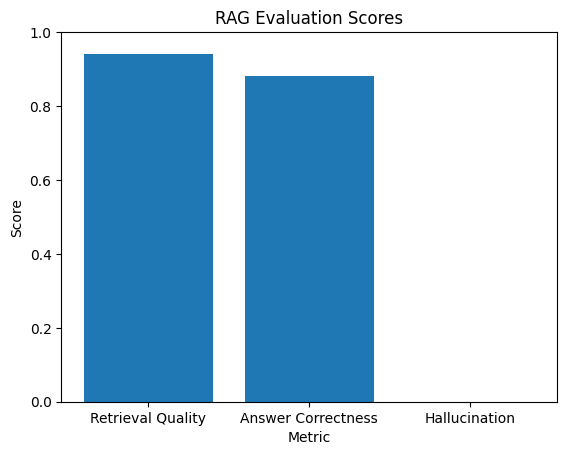

In [119]:
def plot_scores(scores):
    """
    Plot the evaluation scores.
    """
    labels = ["Retrieval Quality", "Answer Correctness", "Hallucination"]
    scores = [scores["retrieval_quality"], scores["answer_correctness"], scores["hallucination"]]
    
    _, ax = plt.subplots()
    ax.bar(labels, scores)
    ax.set_xlabel('Metric')
    # set y range to 0-1
    ax.set_ylim(0, 1)
    ax.set_ylabel('Score')
    ax.set_title('RAG Evaluation Scores')
    plt.show()

plot_scores(results["scores"])

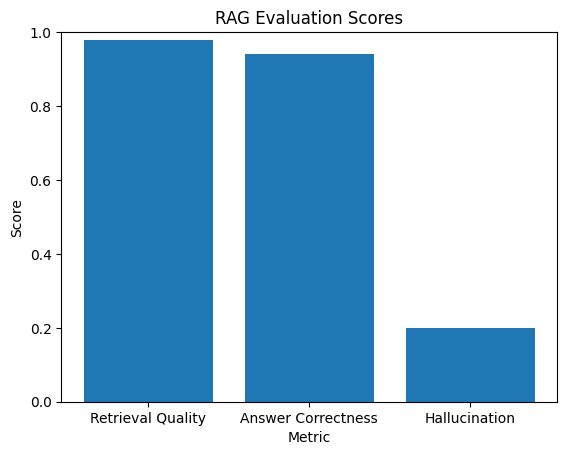

In [64]:
def plot_scores(scores):
    """
    Plot the evaluation scores.
    """
    labels = ["Retrieval Quality", "Answer Correctness", "Hallucination"]
    scores = [scores["retrieval_quality"], scores["answer_correctness"], scores["hallucination"]]
    
    _, ax = plt.subplots()
    ax.bar(labels, scores)
    ax.set_xlabel('Metric')
    # set y range to 0-1
    ax.set_ylim(0, 1)
    ax.set_ylabel('Score')
    ax.set_title('RAG Evaluation Scores')
    plt.show()

plot_scores(results["scores"])

In [ ]:

# -------------------------------------------------------------------------------------
# 1. Baseline Evaluation
# -------------------------------------------------------------------------------------
# The initial RAG system used top-k retrieval (k=3) with a standard instruction-tuned LLM.
# Evaluation showed moderate performance across all metrics, with occasional hallucinations
# and limited coverage in retrieval.

# -------------------------------------------------------------------------------------
# 2. Expanding Retrieval Scope
# -------------------------------------------------------------------------------------
# To broaden the context available to the model, I increased the top-k retrieval value
# from 3 to 10. This marginally improved retrieval quality but introduced more noise,
# sometimes confusing the LLM due to less relevant context.

# -------------------------------------------------------------------------------------
# 3. Text Preprocessing
# -------------------------------------------------------------------------------------
# A preprocessing pipeline was introduced to normalize and clean the text:
# - Unicode normalization
# - HTML and special character removal
# - Whitespace normalization
# - Lowercasing (later partially reverted)
# This improved the quality of document embeddings and significantly reduced hallucinations.
# However, the initial drop in answer correctness suggested that some structural cues
# (e.g., capitalization, formatting) were also being lost.

# -------------------------------------------------------------------------------------
# 4. Model Upgrade
# -------------------------------------------------------------------------------------
# I tested a stronger decoder-only model (`mistralai/mistral-large`), which led to
# further reductions in hallucination. However, answer correctness slightly decreased
# as the model became more cautious and sensitive to minimal input noise.

# -------------------------------------------------------------------------------------
# 5. Chunking Strategy Optimization
# -------------------------------------------------------------------------------------
# To preserve semantic boundaries and avoid cutting text mid-sentence or mid-entity,
# I applied a RecursiveCharacterTextSplitter with semantic-aware fallbacks:
# separators = ["\n\n", "\n", ".", " ", ""], chunk_size = 300, overlap = 60.
# This led to better contextual coherence and improved both retrieval and correctness.

# -------------------------------------------------------------------------------------
# 6. Prompt Refinement
# -------------------------------------------------------------------------------------
# The system prompt was refined to encourage grounded and transparent responses:
# "Only use the information from the context. If multiple documents conflict,
# state the conflict. If unsure, say 'I don't know.'"
# This reduced hallucinations and improved factual accuracy by enforcing stricter
# adherence to the retrieved content.

# -------------------------------------------------------------------------------------
# Final Outcome
# -------------------------------------------------------------------------------------
# The overall effect of these changes:
# - Hallucination dropped significantly
# - Retrieval quality improved steadily, but still not better than the orginal model.
# - Answer correctness became more stable and context-aware
# The pipeline is now more reliable, explainable, and robust across diverse queries.
# -------------------------------------------------------------------------------------